# Smart Bin Model

## Library

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from PIL import Image
import io

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Input, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2
import json

In [87]:
print(tf.__version__)

2.17.0


In [8]:
print("Devices available: ", tf.config.list_physical_devices())
print("GPUs available: ", tf.config.list_physical_devices('GPU'))

Devices available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPUs available:  []


## Data Path Preparation

### Create Path

In [9]:
main_dir = 'Dataset'

In [10]:
if os.path.exists(main_dir):
    for subdir_name in os.listdir(main_dir):
        subdir_path = os.path.join(main_dir, subdir_name)

        if os.path.isdir(subdir_path):
            print(f'Memproses subdir: {subdir_path}')           

Memproses subdir: Dataset\Can
Memproses subdir: Dataset\Plastic Bottle
Memproses subdir: Dataset\UBC


In [11]:
data_paths = []
labels = []

class_list = os.listdir(main_dir)

for classes in class_list:
    class_path = os.path.join(main_dir, classes)
    if os.path.isdir(class_path):
        file_list = os.listdir(class_path)
        for file in file_list:
            f_path = os.path.join(class_path, file)
            data_paths.append(f_path)
            labels.append(classes)

In [12]:
# Path Checking

F_series = pd.Series(data_paths, name='file_paths')
L_series = pd.Series(labels, name='labels')

data_df = pd.concat([F_series, L_series], axis=1)

print(data_df.head())
print(data_df['labels'].value_counts())

                                          file_paths labels
0  Dataset\Can\-2-_jpeg.rf.43dc833156af33fd174c94...    Can
1  Dataset\Can\-3-_jpeg.rf.8cacea1374fba60c6f5ed2...    Can
2  Dataset\Can\-_jpeg.rf.5cb94a5cad118144c78be418...    Can
3  Dataset\Can\1000_F_342875993_cFbHaeM6BvYEbNMu2...    Can
4  Dataset\Can\1000_F_484674280_e2mhjTx7lqxK3FlJ9...    Can
labels
UBC               3620
Plastic Bottle    3461
Can               3450
Name: count, dtype: int64


## Data Split

In [13]:
train_size = 0.8 
test_size = 0.2

In [14]:
train_set, test_set = train_test_split(data_df, test_size=test_size, shuffle=True, stratify=data_df['labels'], random_state=42)

print('train_set length:', len(train_set), 'test_set length:', len(test_set))


train_set length: 8424 test_set length: 2107


## Preprocessing

### Convert Image to RGB

In [15]:
def convert_images_in_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, dirs, files in os.walk(input_folder):
        for file in files:
            file_path = os.path.join(root, file)
            if file.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp')):  # Format gambar yang didukung
                output_path = os.path.join(output_folder, file)
                try:
                    with Image.open(file_path) as img:
                        if img.mode == 'RGBA':
                            img = img.convert('RGB')
                            img.save(output_path)
                except Exception as e:
                    print(f"Terjadi kesalahan saat mengonversi {file_path}: {e}")

input_folder_path = 'Dataset'
output_folder_path = 'Converted_Data'
convert_images_in_folder(input_folder_path, output_folder_path)

### Standarisasi

In [16]:
def get_image_size(filepath):
    try:
        with Image.open(filepath) as img:
            return img.size  # (width, height)
    except Exception as e:
        print(f"Error opening image {filepath}: {e}")
        return None

def find_smallest_image(directory):
    smallest_image = None
    smallest_size = None

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        size = get_image_size(filepath)
        
        if size:
            if smallest_size is None or (size[0] * size[1] < smallest_size[0] * smallest_size[1]):
                smallest_size = size
                smallest_image = filepath
    
    return smallest_image, smallest_size

In [17]:
smallest_image, smallest_size = find_smallest_image(subdir_path)

if smallest_image:
    print(f"The smallest image is {smallest_image} with size {smallest_size}")
else:
    print("No valid images found.")

The smallest image is Dataset\UBC\259_jpg.rf.f30460714f9d9629b2171e9ee9657ca9.jpg with size (128, 128)


In [60]:
# Standarisasi Data
height = 224
width = 224
channels = 3
batch_size = 128
img_shape = (height, width, channels)
img_size = (height, width)

### Augmentation

In [61]:
train_datagen = ImageDataGenerator(
    rescale= 1.0/255.0,
    rotation_range= 20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    fill_mode= 'nearest'
)

In [62]:
# Train Data
train_gen = train_datagen.flow_from_dataframe(train_set,
                                        x_col='file_paths',
                                        y_col= 'labels',
                                        target_size= img_size,
                                        class_mode= 'categorical',
                                        color_mode= 'rgb',
                                        shuffle= True,
                                        batch_size= batch_size
                                        )

Found 8424 validated image filenames belonging to 3 classes.


In [63]:
test_datagen = ImageDataGenerator(
    rescale= 1./255.
)

In [64]:
# Test Data
test_gen = test_datagen.flow_from_dataframe(test_set,
                                        x_col='file_paths',
                                        y_col= 'labels',
                                        target_size= img_size,
                                        class_mode= 'categorical',
                                        color_mode= 'rgb',
                                        shuffle= True,
                                        batch_size= batch_size
                                        )

Found 2107 validated image filenames belonging to 3 classes.


In [65]:
train_categories = list(train_gen.class_indices.keys())
print(train_categories)

['Can', 'Plastic Bottle', 'UBC']


## Data Checking

### Show Images

In [66]:
from PIL import UnidentifiedImageError

def open_image(image_path):
    try:
        with Image.open(image_path) as img:
            pass
    except UnidentifiedImageError:
        print(f"File {image_path} tidak dikenali atau rusak. Menghapus file.")
        os.remove(image_path)
    except Exception as e:
        print(f"Terjadi kesalahan saat membuka {image_path}: {e}")

def process_images_in_folder(root_folder):
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            file_path = os.path.join(root, file)
            if file.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp')):  # Tambahkan format gambar yang diperlukan
                open_image(file_path)

root_folder_path = 'Dataset'
process_images_in_folder(root_folder_path)

In [67]:
def show_samples(generator):
    images, labels = next(generator)
    plt.figure(figsize= (20, 20))
    for i in range(min(len(labels), 20)):
        plt.subplot(5, 4, i + 1)
        plt.imshow(images[i])
        index = np.argmax(labels[i])
        class_name = train_categories[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

In [68]:
print(data_df['labels'].value_counts())

labels
UBC               3620
Plastic Bottle    3461
Can               3450
Name: count, dtype: int64


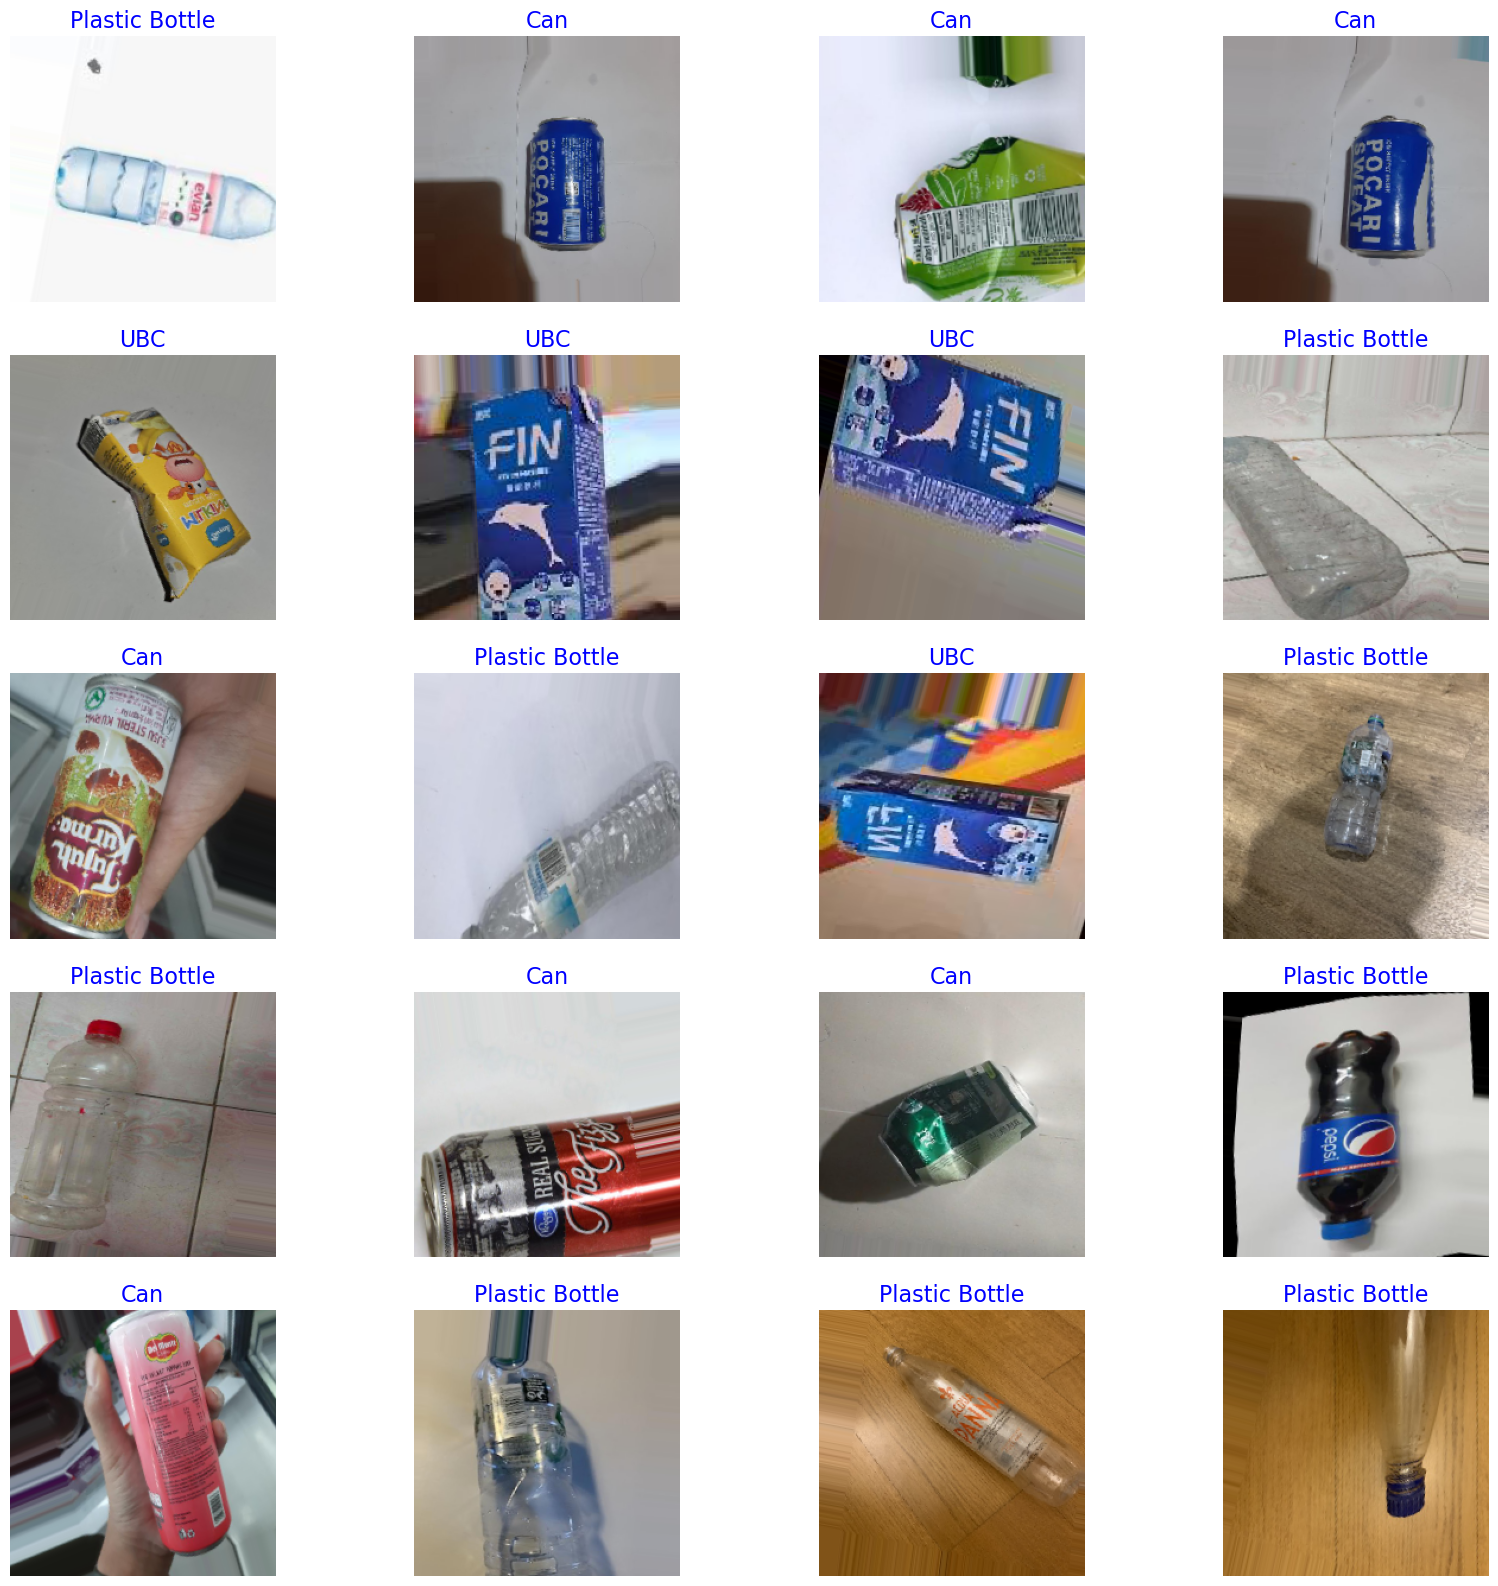

In [69]:
show_samples(train_gen)

## Model

### Design

In [55]:
num_classes = len(classes)

base_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_shape=img_shape)
for layer in base_model.layers:
    layer.trainable = False

extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block_15_project_BN').output)

In [74]:
extractor_output_shape = extractor.output_shape
print("Extractor output shape:", extractor_output_shape)

Extractor output shape: (None, 7, 7, 160)


In [75]:
model = Sequential([
    extractor,
    Conv2D(160, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(80, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(rate=0.5),
    Flatten(),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Build the model
model.build((None, *img_shape))

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_8 (Functional)       │ (None, 7, 7, 160)      │     1,364,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 7, 7, 160)      │       230,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 7, 7, 160)      │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 3, 3, 80)       │       115,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 3, 3, 80)       │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 1, 1, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 1, 80)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           243 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,711,907 (6.53 MB)

 Trainable params: 346,563 (1.32 MB)

 Non-trainable params: 1,365,344 (5.21 MB)

### Training

In [81]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# Checkpoint
class SaveBestModelCallback(Callback):
    def __init__(self, filepath, monitor='val_loss', save_best_only=True):
        super(SaveBestModelCallback, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.save_best_only = save_best_only
        self.best = float('inf') if save_best_only else None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            return
        if self.save_best_only:
            if current < self.best:
                self.best = current
                self.model.save(self.filepath)
        else:
            self.model.save(self.filepath)

checkpoint = SaveBestModelCallback('best_model.h5', monitor='val_loss', save_best_only=True)

In [77]:
history = model.fit(train_gen, 
                    epochs=50, 
                    validation_data=test_gen,
                    steps_per_epoch=len(train_set) // batch_size,
                    validation_steps=len(test_set) // batch_size, 
                    callbacks=[early_stopping, checkpoint],
)

Epoch 1/50


c:\Users\ACER\.conda\envs\ImageClassy\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 9/65 ━━━━━━━━━━━━━━━━━━━━ 4:26 5s/step - accuracy: 0.5882 - loss: 2.0851

KeyboardInterrupt: 

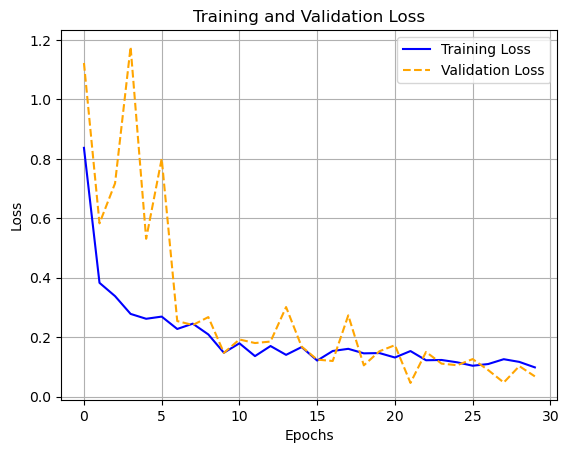

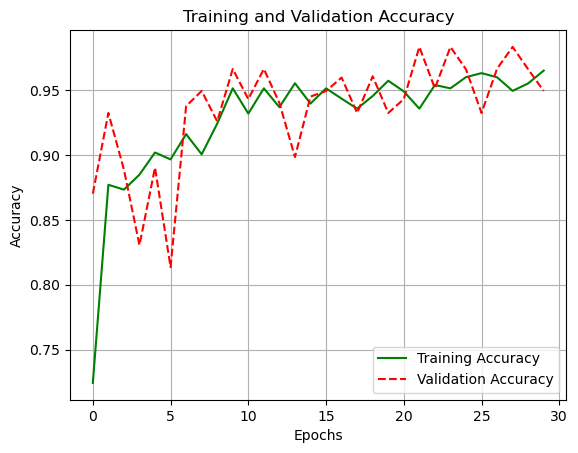

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Convert Model

### Load Model

In [ ]:
best_model = tf.keras.models.load_model('best_model.h5')

### TF-Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(best_model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

NameError: name 'model' is not defined

### TFJS

In [93]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format=keras best_model.h5 tfjs_model

### TF-Serving

In [ ]:
save_tf_serving = os.path.join('TF-Serving')
tf.saved_model.save(best_model, save_tf_serving)

## Inference

## Req.txt

In [ ]:
!pip freeze > requirements.txt